In [4]:
# ─── Cell 1: IMPORTS & DATA LOAD ─────────────────────────────────────────────

import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# confirm inline plots
%matplotlib inline

# build path relative to this notebook
cwd      = Path().resolve()
data_raw = cwd.parent / "data" / "raw"
FILE     = data_raw / "sms.tsv"

print("Notebook running in:", cwd)
print("Loading          :", FILE)
print("Exists?          :", FILE.exists())
print("Total lines      :", sum(1 for _ in open(FILE, encoding="utf-8")))

# load every row (no dedup)
df = pd.read_csv(
    FILE,
    sep="\t",
    header=None,
    names=["label","message"],
    encoding="utf-8"
)

# add numeric and length features
df["label_num"] = df["label"].map({"ham":0,"spam":1})
df["length"]    = df["message"].str.len()

print(f"✅  Data loaded. Shape: {df.shape}\n")
display(df.head())


Notebook running in: C:\Users\ryan5\Documents\SP1_EmailDetect\notebooks
Loading          : C:\Users\ryan5\Documents\SP1_EmailDetect\data\raw\sms.tsv
Exists?          : True
Total lines      : 5574
✅  Data loaded. Shape: (5574, 4)



,label,message,label_num,length
0,ham,"Hey, are we still meeting today?",0,32
1,spam,You have been selected for a $500 Walmart gift...,1,63
2,ham,Lunch at 1 PM?,0,14
3,ham,I'll call you back soon.,0,24
4,ham,"Hey, are we still meeting today?",0,32


Label counts:
 label
ham     4829
spam     745
Name: count, dtype: int64 



<Figure size 800x400 with 0 Axes>

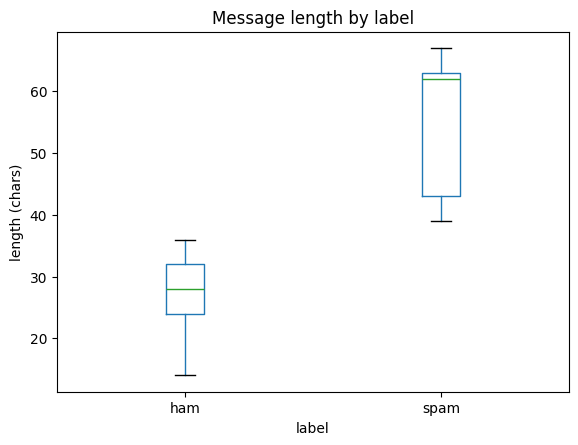

In [5]:
# ─── Cell 2: QUICK EDA ────────────────────────────────────────────────────────

# 1) label balance
counts = df["label"].value_counts()
print("Label counts:\n", counts, "\n")

# 2) length distribution by label
plt.figure(figsize=(8,4))
df.boxplot("length", by="label", grid=False)
plt.title("Message length by label")
plt.suptitle("")    # remove automatic subtitle
plt.ylabel("length (chars)")
plt.show()


In [6]:
# ─── Cell 3: SPLIT & VECTORIZE ───────────────────────────────────────────────

from sklearn.model_selection       import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# split
X = df["message"]
y = df["label_num"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)
print("Train rows:", X_train.shape[0], "  Test rows:", X_test.shape[0])

# tf-idf
vectorizer    = TfidfVectorizer(stop_words="english")
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)

print("✅  Vectorized. Shapes→", 
      "X_train:", X_train_tfidf.shape, 
      "X_test:", X_test_tfidf.shape)


Train rows: 3901   Test rows: 1673
✅  Vectorized. Shapes→ X_train: (3901, 45) X_test: (1673, 45)


In [7]:
# ─── Cell 4: TRAIN & EVALUATE ────────────────────────────────────────────────

from sklearn.linear_model import LogisticRegression
from sklearn.metrics       import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

# train
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

# predict & eval
y_pred = model.predict(X_test_tfidf)
acc    = accuracy_score(y_test, y_pred)

print(f"✅  Test Accuracy: {acc:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["ham","spam"]))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


✅  Test Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      1449
        spam       1.00      1.00      1.00       224

    accuracy                           1.00      1673
   macro avg       1.00      1.00      1.00      1673
weighted avg       1.00      1.00      1.00      1673

Confusion Matrix:
[[1449    0]
 [   0  224]]


In [8]:
# ─── Cell 5: SAVE ARTIFACTS ───────────────────────────────────────────────────

import pickle
from pathlib import Path

# 1) Make a models/ folder at the project root
#    Notebook lives in SP1_EmailDetect/notebooks, so go up two levels:
models_dir = Path().resolve().parent / "models"
models_dir.mkdir(exist_ok=True)

# 2) Dump TF-IDF vectorizer and LogisticRegression model
pickle.dump(vectorizer, open(models_dir/"tfidf.pkl", "wb"))
pickle.dump(model,      open(models_dir/"logreg.pkl", "wb"))

print("✅  Saved tfidf.pkl and logreg.pkl to", models_dir)


✅  Saved tfidf.pkl and logreg.pkl to C:\Users\ryan5\Documents\SP1_EmailDetect\models
